In [1]:
%cd ..

/home/suetin/Projects/VSCode/UltrasoundCardiacReconstruction/HeartReconstruction


/home/suetin/Projects/VSCode/UltrasoundCardiacReconstruction/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [57]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import cv2, os, json
import torch
from tqdm import tqdm
from natsort import natsorted

In [56]:
from src.scripts.models.U2Net import U2Net 
from torch.utils.data import TensorDataset, DataLoader

In [66]:
device = 'cuda'
BATCH_SIZE = 2

## 1. Read Echo-Net Mini Data 

{'LV': [[34, 52], [33, 53], [32, 53], [31, 53], [30, 53], [29, 54], [28, 54], [27, 54], [26, 55], [25, 55], [24, 56], [23, 57], [22, 57], [21, 58], [20, 59], [19, 60], [18, 61], [17, 62], [16, 63], [16, 64], [16, 65], [16, 66], [16, 67], [16, 68], [16, 69], [16, 70], [16, 71], [16, 72], [16, 73], [17, 74], [17, 75], [17, 76], [18, 77], [18, 78], [19, 79], [20, 80], [21, 81], [22, 81], [23, 82], [24, 83], [25, 84], [26, 85], [27, 86], [28, 87], [29, 87], [30, 88], [31, 88], [32, 88], [33, 89], [34, 89], [35, 90], [36, 90], [37, 91], [38, 92], [39, 93], [40, 93], [41, 94], [42, 95], [43, 95], [44, 96], [45, 96], [46, 96], [47, 97], [48, 97], [49, 97], [50, 98], [51, 98], [52, 99], [53, 99], [54, 99], [55, 99], [56, 99], [57, 99], [58, 99], [59, 100], [60, 100], [61, 100], [62, 100], [63, 99], [64, 99], [65, 99], [66, 99], [67, 99], [68, 99], [69, 99], [70, 99], [71, 99], [72, 98], [73, 98], [74, 98], [75, 98], [76, 98], [77, 98], [78, 98], [79, 98], [80, 97], [81, 97], [82, 97], [83, 96]

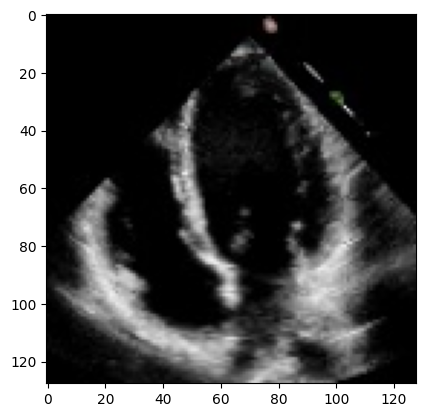

In [4]:
path = 'data/raw/Mini-EchoNet-Dynamic'

img = cv2.imread(os.path.join(path, 'Images', 'frame_1.jpg'))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

with open(os.path.join(path, 'MasksJsonContours', 'mascara1.json')) as f:
    lbl = json.load(f)
    print(lbl)

print(lbl.keys())
plt.imshow(img)

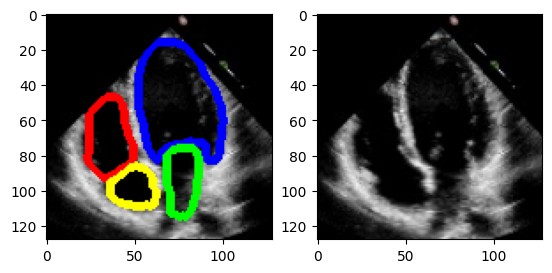

In [5]:
new_img = img.copy()

for key, vals in lbl.items():
    if key == "LV":
        color = (0, 0, 255)
    elif key == "LA":
        color = (0, 255, 0)
    elif key == "RV":
        color = (255, 0, 0)
    else:
        color = (255, 255, 0)
    for val in vals:
        x, y = val[1], val[0]
        cv2.circle(new_img, (x, y), 2, color, -1)

plt.subplot(121)
plt.imshow(new_img);
plt.subplot(122)
plt.imshow(img);

In [39]:
np.array(vals).shape

(74, 2)

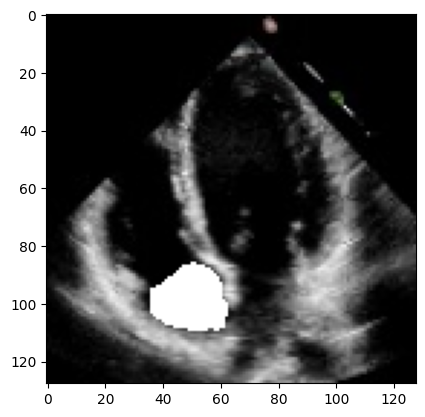

In [43]:
# Fill mask
# points = np.array([[[x1, y1]], ..., [[xn, yn]]])
# # then you can pass these points into the OpenCV function cv2.fillPoly() or cv2.drawContours() to fill in the region.
points = np.array([[[xi, yi]] for yi, xi in vals]).astype(np.int32)
polynomialgon = img.copy()
cv2.fillPoly(polynomialgon, [points], color=[255,255,255])
plt.imshow(polynomialgon)

In [59]:
def get_data(img_paths: list, msk_paths, img_shape=(512, 512), mask_class='LV'):
    """ img_shape - Output image size. Without channels. """

    color = (255, 255, 255)

    n_photo = len(img_paths)      # Batch size
    images = []
    masks = []
    
    for im_path, m_path in tqdm(zip(img_paths, msk_paths), total=n_photo):
        # Open mhd
        image = cv2.imread(im_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #
        mask = np.zeros(image.shape[:2])
        with open(m_path) as f:
            lbl = json.load(f)
        for key, vals in lbl.items():
            if key == mask_class:
                points = np.array([[[xi, yi]] for yi, xi in vals]).astype(np.int32)
                mask = cv2.fillPoly(mask, [points], color=[255,255,255])
                 
        # Resize
        if img_shape:
            # 
            image = cv2.resize(image, dsize=img_shape, interpolation=cv2.INTER_CUBIC)  # INTER_CUBIC
            image = np.clip(image, 0, None)
            image = image / image.max()   # (843, 512, 3)

            mask = cv2.resize(mask, dsize=img_shape, interpolation=cv2.INTER_CUBIC)  # INTER_CUBIC
            mask = np.clip(mask, 0, None)
            mask = mask / mask.max()   # (843, 512, 3)
        if image.ndim == 2:
            image = np.expand_dims(image, axis=-1)
        if mask.ndim == 2:
            mask = np.expand_dims(mask, axis=-1)
        # If we want visualize
        # image = np.transpose(image, (1, 2, 0)) 
        image = np.transpose(image, (2, 0, 1)) 
        mask = np.transpose(mask, (2, 0, 1)) 
        # image = np.expand_dims(image, axis=0)  # (1, 3, 512, 512)

        images.append(image)
        masks.append(mask)
        # break
    return np.array(images).astype(np.float32), np.array(masks).astype(np.float32)

In [60]:
# All paths
main_ds_path = 'data/raw/Mini-EchoNet-Dynamic'
im_main_path = os.path.join(main_ds_path, 'Images')
msk_main_path = os.path.join(main_ds_path, 'MasksJsonContours')
img_paths = [os.path.join(im_main_path, im_name) for im_name in natsorted(os.listdir(im_main_path))]
msk_paths = [os.path.join(msk_main_path, im_name) for im_name in natsorted(os.listdir(msk_main_path))]
msk_paths[:5]

['data/raw/Mini-EchoNet-Dynamic/MasksJsonContours/mascara1.json',
 'data/raw/Mini-EchoNet-Dynamic/MasksJsonContours/mascara2.json',
 'data/raw/Mini-EchoNet-Dynamic/MasksJsonContours/mascara3.json',
 'data/raw/Mini-EchoNet-Dynamic/MasksJsonContours/mascara4.json',
 'data/raw/Mini-EchoNet-Dynamic/MasksJsonContours/mascara5.json']

100%|██████████| 100/100 [00:00<00:00, 431.32it/s]


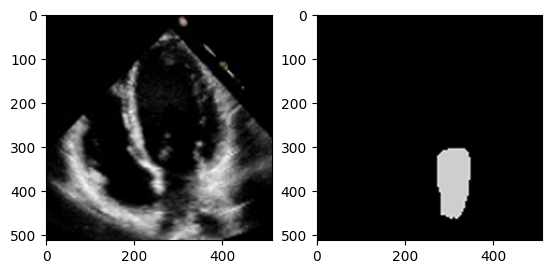

In [61]:
images, masks = get_data(img_paths, msk_paths, img_shape=(512, 512), mask_class='RV')

plt.subplot(121)
plt.imshow(np.transpose(images[0], (1, 2, 0)));
plt.subplot(122)
plt.imshow(np.transpose(masks[0], (1, 2, 0)), 'gray');

In [62]:
# Restore images to suitable images of opencv style
def ImgForPlot(img):
    # img = np.einsum('ijk->jki', img)
    # img = (127.5*(img+1)).astype(np.uint8)
    try:
        img = img.cpu().detach().numpy()
        return np.transpose(img, (1, 2, 0))
    except:
        print("Already numpy.array")
        return np.transpose(img, (1, 2, 0))

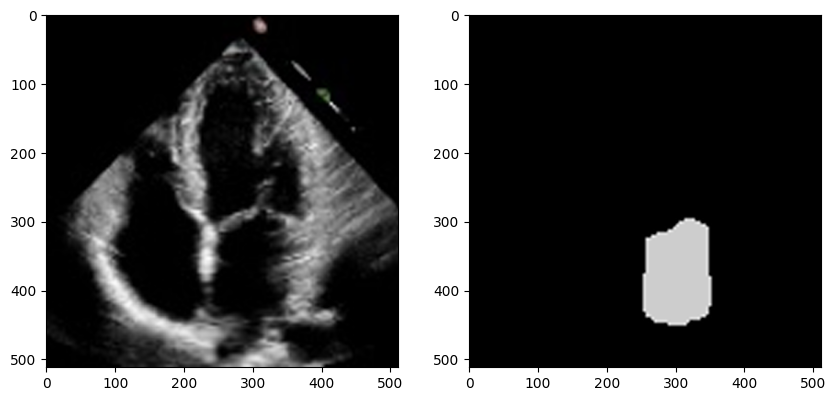

In [64]:
dataset = TensorDataset(torch.from_numpy(images), torch.from_numpy(masks))
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

im, m = dataset[25]
fig = plt.figure(figsize=(10,10))

plt.subplot(121)
plt.imshow(ImgForPlot(im));
plt.subplot(122)
plt.imshow(ImgForPlot(m), 'gray');

## 2. Load Trained Model

- Transfer weights into new model (Transfer Learning)
- Freeze Decoder
- Train model in new data
- Use Augumentation

In [1]:
model_name = 'u2net-LV'
model_saved_dir = 'results/U2Net'

model_path = F"{model_saved_dir}/{model_name}_best.pt"  # _best

model = U2Net().to(device)
model.load_state_dict(torch.load(model_path))

NameError: name 'U2Net' is not defined